Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. 

Применить модели на тестовую выборку и оценить корреляцию.

Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.

Выполнить задание 2 для трех моделей.

(опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.

(опция) Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.

In [132]:
import time
import pickle
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import gmean, rankdata
import seaborn as sns
from matplotlib import pyplot as plt


import warnings
warnings.filterwarnings("ignore")

Использован baseline с кодировкой категориальных признаков

In [4]:
def encode_labels(data: pd.DataFrame) -> pd.DataFrame:
    
    """
    Применяет Label Encoder к каждому категориальному признаку.
    
    Input:
    ------
    data: pd.DataFrame
        Исходный датасет
    """
    cat_cols = data.select_dtypes(include="object")
    for col in cat_cols:
        data[col] = LabelEncoder().fit_transform(data[col].fillna('null'))
        
    return "Done"


In [12]:
with open('data/baseline_data.pkl', 'rb') as f:
    data = pickle.load(f)
    
# Закодируем категориальные признаки для унификации модели
encode_labels(data)

# Выделяем 
mask = data["target"].isnull()
features_to_drop = ["application_number", "target"]

train, test = data.loc[~mask], data.loc[mask]

target, test_id = train["target"], test["application_number"]
train = train.drop(features_to_drop, axis=1)
test = test.drop(features_to_drop, axis=1)

categorial = train.dtypes[train.dtypes == "object"].index
numerical = list(set(train.columns) - set(categorial))

train = train.replace(np.inf, np.nan)
train = train.replace(-np.inf, np.nan)

In [13]:
train.head(3)

,name_contract_type,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,...,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3
0,0,1,1.0,157500.0,855000.0,25128.0,4,1,0.019101,15728.0,...,9.149506,3008.4075,0.006399,0.000699,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111
1,0,3,NaN,NaN,NaN,NaN,5,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,0.0,135000.0,1006920.0,42660.0,1,1,0.026392,21557.0,...,5.958264,3562.9200,NaN,NaN,NaN,686869.876357,269722.588880,NaN,29100.493510,11427.288803


In [14]:
# class CrossValidation():
#     def __init__(self, params, X, y, cv):
#         self.params = params
#         self.X = X
#         self.y = y
#         self.cv = cv
        

### Используемые функции

In [98]:
def cross_validation(model, X, y, cv, eval_mode='train'):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    
    assert eval_mode in ['train', 'valid'], 'eval mode must be "train" or "valid"'
    
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, eval_mode: {eval_mode}, {X.shape[0]} rows, {X.shape[1]} cols")
#     X[categorical] = X[categorical].astype(str)
    X = X.fillna(-99999)
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        """FIXME - дополнительные обработчики под модели и режимы обучения"""
        
        if "ExtraTreesClassifier" in str(model):  
            model.fit(
                X=x_train, y=y_train)
        else:   
            model.fit(
                X=x_train, y=y_train,
                eval_set=[(x_train, y_train), (x_valid, y_valid)],
                verbose=0)
    
        if eval_mode=='train':
            oof_preds[train_idx] = model.predict_proba(x_train)[:, 1]
            score = roc_auc_score(y_train, oof_preds[train_idx])
            print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
            folds_scores.append(round(score, 5))
            estimators.append(model)
            
        else:
            oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
            score = roc_auc_score(y_valid, oof_preds[valid_idx])
            print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
            folds_scores.append(round(score, 5))
            estimators.append(model)
            
        """FIXME end"""

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

### Получение OOF прогнозов

In [16]:
xgb_params = {
    "n_estimators": 100,
    "learning_rate": 0.01,
    "eval_metric": "auc",
    "max_bin": 20,
    "max_depth": 6,
}

cb_params = {
    "n_estimators": 100,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

lgbm_params = {
    "n_estimators": 100,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "num_leaves": 25,
    "l2_leaf_reg": 10,
    "early_stopping_round": 50,
    "thread_count": 6,
    "random_seed": 42
}

cv = KFold(n_splits=5, random_state=7777, shuffle=True)

xgb = XGBClassifier(**xgb_params)
catb = CatBoostClassifier(**cb_params)
lgbm = LGBMClassifier(**lgbm_params)

In [17]:
# Модели, OOF для LGBM и XGB моделей (train, valid)

# LGBM
train_lgbm_estimators, train_lgbm_oof_preds = cross_validation(model=lgbm,
                                                 X=train,
                                                 y=target,
                                                 cv=cv,
                                                 eval_mode='train')

valid_lgbm_estimators, valid_lgbm_oof_preds = cross_validation(model=lgbm,
                                                 X=train,
                                                 y=target,
                                                 cv=cv,
                                                 eval_mode='valid')

# XGB
train_xgb_estimator, train_xgb_oof_preds = cross_validation(model=xgb,
                                               X=train,
                                               y=target,
                                               cv=cv,
                                               eval_mode='train')



valid_xgb_estimator, valid_xgb_oof_preds = cross_validation(model=xgb,
                                               X=train,
                                               y=target,
                                               cv=cv,
                                               eval_mode='valid')

# CAT BOOST
train_catb_estimator, train_catb_oof_preds = cross_validation(model=catb,
                                               X=train,
                                               y=target,
                                               cv=cv,
                                               eval_mode='train')

valid_catb_estimators, valid_catb_oof_preds = cross_validation(model=catb,
                                                 X=train,
                                                 y=target,
                                                 cv=cv,
                                                 eval_mode='valid')

Sat Sep 26 07:58:10 2020, Cross-Validation, 110093 rows, 52 cols
Fold 1, Valid score = 0.725
Fold 2, Valid score = 0.72523
Fold 3, Valid score = 0.72379
Fold 4, Valid score = 0.72202
Fold 5, Valid score = 0.72472
Score by each fold: [0.725, 0.72523, 0.72379, 0.72202, 0.72472]
Sat Sep 26 07:58:29 2020, Cross-Validation, 110093 rows, 52 cols
Fold 1, Valid score = 0.70555
Fold 2, Valid score = 0.70667
Fold 3, Valid score = 0.71877
Fold 4, Valid score = 0.71586
Fold 5, Valid score = 0.70886
Score by each fold: [0.70555, 0.70667, 0.71877, 0.71586, 0.70886]
Sat Sep 26 07:58:46 2020, Cross-Validation, 110093 rows, 52 cols
Fold 1, Valid score = 0.73676
Fold 2, Valid score = 0.73444
Fold 3, Valid score = 0.73494
Fold 4, Valid score = 0.73281
Fold 5, Valid score = 0.73407
Score by each fold: [0.73676, 0.73444, 0.73494, 0.73281, 0.73407]
Sat Sep 26 08:01:45 2020, Cross-Validation, 110093 rows, 52 cols
Fold 1, Valid score = 0.70048
Fold 2, Valid score = 0.70028
Fold 3, Valid score = 0.71537
Fold 4

### Сбор статистик

In [179]:
# train_corr_lgbm_xgb = np.correlate(train_lgbm_oof_preds, train_xgb_oof_preds)
# valid_corr_lgbm_xgb = np.correlate(valid_lgbm_oof_preds, valid_xgb_oof_preds)
# print(f"Кросс-корреляция прогнозов на тренеровочной выборке для 2-х моделей: {round(train_corr_lgbm_xgb[0], 1)}")
# print(f"Кросс-корреляция прогнозов на валидационной выборке для 2-х моделей: {round(valid_corr_lgbm_xgb[0], 1)}")

In [44]:
rankdata(valid_catb_oof_preds, method='average')

array([ 8992. , 62986.5, 54405. , ..., 62986.5, 23131. , 58132. ])

In [52]:
# Сбор oof предсказаний в ДатаФрейм

train_oof_preds = pd.DataFrame(np.vstack((train_lgbm_oof_preds,
                                          train_xgb_oof_preds,
                                          train_catb_oof_preds
                                         )).T,
                               columns=['tLGBM_OOF', 'tXGB_OOF', 'tCATB_OOF'])

valid_oof_preds = pd.DataFrame(np.vstack((valid_lgbm_oof_preds,
                                          valid_xgb_oof_preds,
                                          valid_catb_oof_preds
                                         )).T,
                               columns=['vLGBM_OOF', 'vXGB_OOF', 'vCATB_OOF'])

oof_df = pd.concat([train_oof_preds, valid_oof_preds], axis=1)
oof_df.head(2)

,tLGBM_OOF,tXGB_OOF,tCATB_OOF,vLGBM_OOF,vXGB_OOF,vCATB_OOF
0,0.041538,0.195082,0.115208,0.040896,0.192401,0.121352
1,0.082987,0.236103,0.181853,0.080832,0.234766,0.180923


**Среднее арифмитическое, геометрическое, усредненные ранги**

In [61]:
oof_df['Stats_group'] = 0  # метка огрегирования кастомных статистик

def avg_rank(x):
    """Усреднение ранга по признаку"""
    
    return np.mean(rankdata(x))

f = {f: [np.mean, gmean, avg_rank] for f in oof_df.columns[:-1]}  # генерация статистик для каждого признака
oof_df.groupby('Stats_group').agg(f).iloc[:,:]

tLGBM_OOF                     tXGB_OOF                     \
                 mean     gmean avg_rank      mean     gmean avg_rank   
Stats_group                                                             
0            0.080957  0.074332  55047.0  0.234795  0.231971  55047.0   

            tCATB_OOF                    vLGBM_OOF                     \
                 mean     gmean avg_rank      mean     gmean avg_rank   
Stats_group                                                             
0            0.168956  0.164084  55047.0  0.080839  0.074225  55047.0   

             vXGB_OOF                    vCATB_OOF                     
                 mean     gmean avg_rank      mean     gmean avg_rank  
Stats_group                                                            
0            0.234727  0.231925  55047.0  0.173139  0.168341  55047.0

**Корреляции**

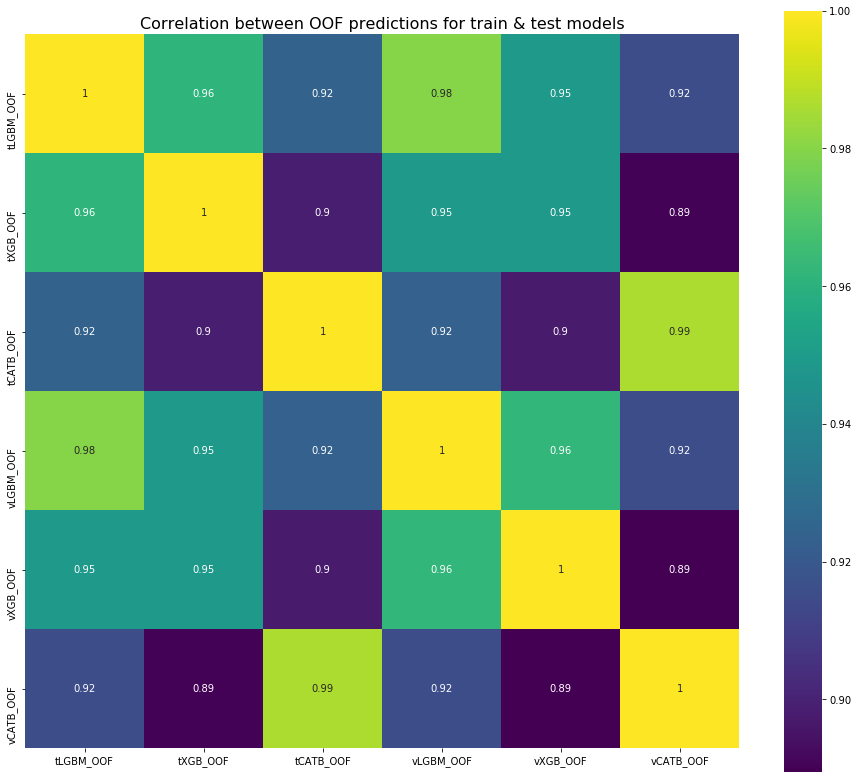

In [68]:

correlation = oof_df.drop("Stats_group",axis=1).corr()

fig, axes = plt.subplots(figsize = (16,14))
plt.title("Correlation between OOF predictions for train & test models", y=1, size=16)
sns.heatmap(correlation, square=True, cmap="viridis", annot=True);

#  Усреднение прогнозов моделей

In [128]:
# a = np.array([1,2,3,4])
# b = np.array([7,6,5,4])
# c = np.mean(np.vstack((a,b)).T,axis=1)

In [148]:
# Расчет средней вероятности предсказания модели

mean_train_preds = np.mean(np.vstack((train_xgb_oof_preds, train_lgbm_oof_preds, train_catb_oof_preds)).T,axis=1)
valid_oof_score = roc_auc_score(
    target, mean_train_preds
)
print(f"Train OOF-score for mean of 3 models (xgb, lgbm, catb) = {round(valid_oof_score, 5)}")

mean_valid_preds = np.mean(np.vstack((valid_xgb_oof_preds, valid_lgbm_oof_preds, valid_catb_oof_preds)).T,axis=1)
train_oof_score = roc_auc_score(
    target, mean_valid_preds
)
print(f"Valid OOF-score for mean of 3 models (xgb, lgbm, catb) = {round(train_oof_score, 5)}")

Train OOF-score for mean of 3 models (xgb, lgbm, catb) = 0.72681
Valid OOF-score for mean of 3 models (xgb, lgbm, catb) = 0.71006


In [151]:
X_train_meta = train_oof_preds
X_valid_meta = valid_oof_preds

meta_clf = LogisticRegression(random_state=42, solver="liblinear")

meta_clf.fit(X_train_meta, target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [153]:
meta_pred = meta_clf.predict_proba(X_valid_meta)[:, 1]
meta_oof_score = roc_auc_score(target, meta_pred) 
print(f"Train OOF-score for mean of 3 models (xgb, lgbm, catb) = {round(meta_oof_score, 5)}")

Train OOF-score for mean of 3 models (xgb, lgbm, catb) = 0.70709


# Stacking

In [154]:
from mlxtend.classifier import StackingCVClassifier

In [157]:
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=0.3, stratify=target)

In [170]:
s_xgb_params = {
    "n_estimators": 100,
    "learning_rate": 0.01,
    "max_bin": 20,
    "max_depth": 6,
}

s_cb_params = {
    "n_estimators": 100,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 10,
#     "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

s_lgbm_params = {
    "n_estimators": 100,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "num_leaves": 25,
    "l2_leaf_reg": 10,
#     "early_stopping_round": 50,
    "thread_count": 6,
    "random_seed": 42
}

xxgb = XGBClassifier(**s_xgb_params)
xcatb = CatBoostClassifier(**s_cb_params)
xlgbm = LGBMClassifier(**s_lgbm_params)

In [171]:

stack = StackingCVClassifier(classifiers=(xxgb, xlgbm, xcatb),
                            meta_classifier=catb, cv=5,
                            use_probas=True,
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=False,
                            random_state=42,
                            n_jobs=6)

stack.fit(X_train, y_train)

0:	learn: 0.6820433	total: 48.6ms	remaining: 4.81s
10:	learn: 0.5873039	total: 472ms	remaining: 3.81s
20:	learn: 0.5144159	total: 900ms	remaining: 3.39s
30:	learn: 0.4588451	total: 1.34s	remaining: 2.98s
40:	learn: 0.4160517	total: 1.75s	remaining: 2.51s
50:	learn: 0.3826620	total: 2.17s	remaining: 2.08s
60:	learn: 0.3574104	total: 2.57s	remaining: 1.64s
70:	learn: 0.3372493	total: 3s	remaining: 1.23s
80:	learn: 0.3214000	total: 3.43s	remaining: 806ms
90:	learn: 0.3092301	total: 3.85s	remaining: 381ms
99:	learn: 0.3002041	total: 4.26s	remaining: 0us
0:	total: 48.8ms	remaining: 4.83s
10:	total: 492ms	remaining: 3.98s
20:	total: 931ms	remaining: 3.5s
30:	total: 1.36s	remaining: 3.04s
40:	total: 1.78s	remaining: 2.56s
50:	total: 2.21s	remaining: 2.12s
60:	total: 2.63s	remaining: 1.68s
70:	total: 3.07s	remaining: 1.25s
80:	total: 3.49s	remaining: 819ms
90:	total: 3.92s	remaining: 388ms
99:	total: 4.31s	remaining: 0us


StackingCVClassifier(classifiers=(XGBClassifier(base_score=None, booster=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=None,
                                                gamma=None, gpu_id=None,
                                                importance_type='gain',
                                                interaction_constraints=None,
                                                learning_rate=0.01, max_bin=20,
                                                max_delta_step=None,
                                                max_depth=6,
                                                min_child_weight=None,
                                                missing=nan,
                                                monotone_constraints=None,
                                                n_estimat...
      

In [164]:
stack_pred = stack.predict_proba(X_valid)
score = roc_auc_score(y_valid, stack_pred[:, 1])
score

0.7253857612064327

# Random Forest

In [99]:
rf_params = {
    "n_estimators": 50,
    "max_features": 'auto',
    "min_samples_leaf": 1,
    "max_depth": 8,
    "verbose": 0,
    "random_state": 42,
    "n_jobs": 6,
}

# TODO: Настроить параметры RF
rf = ExtraTreesClassifier(**rf_params)

# RF
train_rf_estimator, train_rf_oof_preds = cross_validation(model=rf,
                                               X=train,
                                               y=target,
                                               cv=cv,
                                               eval_mode='train')



valid_rf_estimator, valid_rf_oof_preds = cross_validation(model=rf,
                                               X=train,
                                               y=target,
                                               cv=cv,
                                               eval_mode='valid')

Sat Sep 26 10:46:51 2020, Cross-Validation, 110093 rows, 52 cols
Fold 1, Valid score = 0.72602
Fold 2, Valid score = 0.72874
Fold 3, Valid score = 0.72687
Fold 4, Valid score = 0.72855
Fold 5, Valid score = 0.72754
Score by each fold: [0.72602, 0.72874, 0.72687, 0.72855, 0.72754]
Sat Sep 26 10:47:01 2020, Cross-Validation, 110093 rows, 52 cols
Fold 1, Valid score = 0.68541
Fold 2, Valid score = 0.69184
Fold 3, Valid score = 0.70323
Fold 4, Valid score = 0.71454
Fold 5, Valid score = 0.69104
Score by each fold: [0.68541, 0.69184, 0.70323, 0.71454, 0.69104]


In [102]:
oof_df_plus_rf = oof_df.copy()
oof_df_plus_rf['tRF_OOF'] = train_rf_oof_preds
oof_df_plus_rf['vRF_OOF'] = valid_rf_oof_preds

In [107]:
oof_df_plus_rf

,tLGBM_OOF,tXGB_OOF,tCATB_OOF,vLGBM_OOF,vXGB_OOF,vCATB_OOF,Stats_group,tRF_OOF,vRF_OOF
0,0.041538,0.195082,0.115208,0.040896,0.192401,0.121352,0,0.045286,0.054822
1,0.082987,0.236103,0.181853,0.080832,0.234766,0.180923,0,0.085334,0.082552
2,0.066743,0.212210,0.161313,0.072758,0.219825,0.170982,0,0.067078,0.072354
3,0.155389,0.311885,0.237678,0.160514,0.304456,0.257483,0,0.141914,0.115971
4,0.082987,0.236103,0.181853,0.082178,0.235703,0.195967,0,0.085334,0.084481
...,...,...,...,...,...,...,...,...,...
110088,0.082987,0.236103,0.181853,0.083719,0.237578,0.188364,0,0.085334,0.085868
110089,0.070775,0.222952,0.150682,0.064996,0.219734,0.152379,0,0.083699,0.076149
110090,0.082987,0.236103,0.181853,0.080832,0.234766,0.180923,0,0.085334,0.082552
110091,0.049879,0.203344,0.119465,0.051011,0.213510,0.136513,0,0.039710,0.039768


In [108]:
oof_df_plus_rf['Stats_group'] = 0  # метка огрегирования кастомных статистик

def avg_rank(x):
    """Усреднение ранга по признаку"""
    return np.mean(rankdata(x))

f = {f: [np.mean, gmean, avg_rank] for f in oof_df_plus_rf[["tRF_OOF", "vRF_OOF"]]}  # генерация статистик для каждого признака
oof_df_plus_rf.groupby('Stats_group').agg(f)

tRF_OOF                     vRF_OOF                   
                 mean     gmean avg_rank     mean     gmean avg_rank
Stats_group                                                         
0            0.080915  0.075751  55047.0  0.08083  0.075817  55047.0